# `Проверка работы оборудования и регистрации респондентов, пользующихся услугами телевизионного вещания`.

**Автор:**

* Бессонов Евгений  
* [Адрес в телеграмм](https://t.me/EMskv "t.me/EMskv")  
* [Портфолио с JupiterNotebook проекта](https://github.com/evgeniy-yandex/Data_Science "github")

# Описание проекта.


**Описание данных**

Для работы получены 2 файла:

1. `src_OnOff.csv` - данные по фактическому включению/выключению пиплметра (измерительное устройство для фиксации телесмотрения).  

    *Описание полей данных:*  
* `PassportNumber` - номер регистрационого паспорта владельца.
* `UnitNumber` - номер телевизора в домохозяйстве (ДХ).
* `DeviceState` - cтатус работы телевизора 'ON'/'OFF'.
* `Begin` - дата и время его включения телевизора.
* `End` - дата и время его выключения телевизора.

2. `src_survey.csv` - данные с результатами опроса клиентов телевизионной компании.  

    *Описание полей данных:*  
* `code` - код опроса клиента (порядковый номер), 
* `passport` - номер регистрационого паспорта владельца телевизора, 
* `unit` - номер телевизора в домохозяйстве,
* `num_people` - размер ДХ, количество жильцов в доме,
* `button` - идентификатор респондента,
* `tv state` - статус телевизора по утверждению респондента,
* `day` - дата опроса,
* `cs_start` - время начала опроса,
* `cs_finish` - время окончания опроса,
* `see` - наличие фактической регистрации на пиплметре,
* `display` - наличие респондента в комнате с телевизором согласно опросу.
  
По некоторому графику в домохозяйствах (ДХ) проверяется, кто из респондентов находится в комнате с включенным телевизором. В ДХ может быть несколько приборов (телевизоров), могут проживать несколько респондентов. В файле с результатами опроса содержится информация по каждому телевизору и каждому респонденту. Далее, результат опроса сравнивается с данными регистрации респондента на пиплметре во время опроса, результат сравнения фиксируется в таблице.


**Задача на проект** 

Проанализировать:
1. Количество ситуаций (абс, %), когда прибор фактически выключен (данные в таблице src_OnOff), а респондент утверждает, что включен
2. Количество ситуаций (абс, %), когда прибор фактически включен (данные в таблице src_OnOff), а респондент утверждает, что выключен
3. Выделить ДХ с размером более 1 человека, среди них ситуации, телевизор фактически включен, респондент по данным опроса находится в комнате с включенным телевизором, регистрации нет, а у других респондентов в этом ДХ регистрация на этом телевизоре есть. Необходимо сгруппировать результат в зависимости от размера ДХ. 


**План работы.**

1. Импорт библиотек.
2. Загрузка файлов с данными `src_OnOff.csv`, `src_survey.csv` 
3. Изучение датасетов и проведение первичной обработки данных.
    * Размеры датасетов.
    * Сущность признаков.
    * Типы данных.
    * Диапазоны значений признаков.
    * Наличие/отсутствие дубликатов.
    * Наличие/отсутствие пропусков данных.
    * Приведение названия столбцов к стилю `snake_case`.
4. Проведение EDA анализа.  
    * Приведение к формату 'datetime' данных
    * Добавление к данным опроса 'data_survey' значения фактического состояния device_state из 'data_onoff'.
    * Изучение значения фактического состояния device_state в 'data_onoff'. 
5. Выполнение поставленных заданий.
    * Задача 1.
    * Задача 2.
    * Задача 3.
6. Оформление итоговых выводов.

# 1. Импорт библиотек.

In [1]:
# Все import соберем в начале проекта:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
from skimpy import skim, clean_columns
from datetime import datetime
import numpy as np
import seaborn as sns
import time

from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# Настроим вид таблиц:
pd.set_option("display.max_rows", 250)
pd.set_option("display.max_columns", 50) 

# 2. Загрузка файлов с данными.

Изучили файлы с предоставленными данными `src_OnOff.csv` и `src_survey.csv`, решили использовать символ **запятая** для разделения данных:

In [2]:
# Вспомогательная функция для чтения файлов с данными
def load_dataset(file_name, separator):
    '''
    Функция для проверки нахождения файла и загрузки датафрейма.
    '''
    if os.path.exists(file_name):
        data = pd.read_csv(file_name, sep = separator)
        print('Dataset', file_name, 'is loaded successfully.')
        return data
    else:
        print('Something with', file_name, 'is wrong.')


# Загрузка данных по фактическому включению/выключению пиплметра         
data_onoff = load_dataset('src_OnOff.csv', '\t');

# Загрузка данных с результатами опроса    
data_survey = load_dataset('src_survey.csv', ';');

Dataset src_OnOff.csv is loaded successfully.
Dataset src_survey.csv is loaded successfully.


# 3. Изучение датасетов и проведение первичной обработки данных.

Так как у нас есть ДВА датасета, создадим вспомогательную функцию для единообразного их изучения.

In [3]:
def view_df(df):
    '''
    Функция для единообразного изучения датафреймов.
    1. Контроль размера датасета.
    2. Проверка на соответствие наименований столбцов стилю snake_case.
    3. Вывод основных данных по датасету.
    4. Распечатка на экране первых трёх объектов датасета.
    
    В дальнейшем вероятно, будем избавляться от части объектов. Чтобы понимать, 
    какую часть данных потеряли, сохраним возвращая, 
    начальное значение количества объектов в датасете:
    '''
    skim(df)
    display(df.head(3))
    display(df.tail(3))
    print('Количество дубликатов:', df.duplicated().sum())
    
    print('Количество пропущенных значений по всем признакам:', df.isnull().sum().sum())
    
    return df.shape[0]

## 3.1. Рассмотрим данные, содержащиеся в обоих датафреймах.

In [4]:
# Изучим содержимое датафрейма `data_onoff`:

ininial_size_data_onoff = view_df(data_onoff)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 642134 │ │ string      │ 3     │                                                          │
│ │ Number of columns │ 5      │ │ int32       │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name      ┃ NA  ┃ NA %  ┃ mean     ┃ sd       ┃ p0      ┃ p25      ┃ p75       ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ PassportNumber   │   0 │     0 │  6000000 │  5900000 │  100000 │  1200000 │  10000000 │  20000000 │ █▂▁▂▂▁ │  │
│ │ UnitNumber       │   0 │     0 │     0.44 │     0.67 │       0 │        0 │         1 │         6 │  █▃▁   │  │
│ └──────────────────┴─────┴───────┴──────────┴──────────┴─────────┴──────────┴───────────┴───────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ DeviceState               │       0 │          0 │                            1 │                   640000 │  │
│ │ Begin                     │       0 │          0 │                            1 │                   640000 │  │
│ │ End                       │       0 │          0 │                            1 │                   640000 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,PassportNumber,UnitNumber,DeviceState,Begin,End
0,10100003,0,OFF,2022-02-07 02:00:00.000,2022-02-08 02:00:00.000
1,10100003,0,OFF,2022-02-08 02:00:00.000,2022-02-08 11:48:42.000
2,10100003,0,ON,2022-02-08 11:48:42.000,2022-02-08 12:36:55.000


,PassportNumber,UnitNumber,DeviceState,Begin,End
642131,502286,0,OFF,2022-02-15 21:43:15.000,2022-02-15 22:09:59.000
642132,502286,0,ON,2022-02-15 22:09:59.000,2022-02-15 22:19:33.000
642133,502286,0,OFF,2022-02-15 22:19:33.000,2022-02-16 02:00:00.000


Количество дубликатов: 0
Количество пропущенных значений по всем признакам: 0


**Отмечаем**, что в датасете с автоматической фиксацией состояния телевизора у пользователей:
* Количество записей 642134.
* Количество признаков равно 5.
* Поля `номер паспорта владельца` 'PassportNumber' и `номер телевизора в домохозяйстве` 'UnitNumber' имеют тип int.
* Диапазон номеров телевизоров в домах от 0 до 6. Т.е., максимальное их количество в одном доме - 7 шт.
* `Статус работы телевизора` 'DeviceState', `даты и времени` его включения 'Begin' и выключения 'End' имеют тип string.
* Признаки `даты и времени` включения 'Begin' и выключения 'End' телевизора содержат и информацию о дате, и о времени.
* Дубликатов нет.
* Пропусков данных нет.

In [5]:
# Изучим содержимое датафрейма `data_survey`:

ininial_size_data_survey = view_df(data_survey)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 207    │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 11     │ │ int32       │ 4     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name            ┃ NA  ┃ NA %  ┃ mean     ┃ sd    ┃ p0       ┃ p25      ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ code                   │   0 │     0 │   260000 │   200 │   260000 │   260000 │  260000 │  260000 │ ▅    █ │  │
│ │ passport               │   0 │     0 │  1200000 │  2200 │  1200000 │  1200000 │ 1200000 │ 1200000 │ ▂▂▁▇█▃ │  │
│ │ unit                   │   0 │     0 │     0.65 │  0.73 │        0 │        0 │       1 │       2 │ █  ▆ ▂ │  │
│ │ Кол-во человек в сем   │   0 │     0 │      3.2 │   1.3 │        1 │        2 │       4 │       7 │ ▁▇█▇ ▂ │  │
│ └────────────────────────┴─────┴───────┴──────────┴───────┴──────────┴──────────┴─────────┴─────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ button                    │       0 │          0 │                            1 │                      210 │  │
│ │ tv state                  │       0 │          0 │                            1 │                      210 │  │
│ │ day                       │       0 │          0 │                            1 │                      210 │  │
│ │ cs_start                  │       0 │          0 │                            1 │                      210 │  │
│ │ cs_finish                 │       0 │          0 │                            1 │                      210 │  │
│ │ see                       │       0 │          0 │                            1 │                      210 │  │
│ │ display                   │       0 │          0 │                            1 │                      210 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,code,passport,button,tv state,unit,day,cs_start,cs_finish,see,display,Кол-во человек в семье 4+
0,258104,1204558,А,выключен,0,07.02.22,16:25:18,16:26:09,нет регистрации,нет в комнате,1
1,258106,1205697,Б,включён,0,07.02.22,16:50:18,16:53:17,нет регистрации,в комнате,3
2,258106,1205697,А,включён,0,07.02.22,16:50:18,16:53:17,нет регистрации,нет в комнате,3


,code,passport,button,tv state,unit,day,cs_start,cs_finish,see,display,Кол-во человек в семье 4+
204,258546,1212330,Д,включён,0,14.02.22,18:44:21,18:46:04,есть регистрация,в комнате,4
205,258548,1212873,А,включён,0,14.02.22,19:24:42,19:26:55,есть регистрация,в комнате,1
206,258552,1212916,А,включён,0,14.02.22,19:39:23,19:41:36,есть регистрация,в комнате,1


Количество дубликатов: 0
Количество пропущенных значений по всем признакам: 0


**Отмечаем**, что в датасете с результатами опроса респондентов о состоянии их телевизора:
* Количество записей 207.
* Количество признаков равно 11.
* Поля `код опроса` code, `номер паспорта владельца` 'passport, `номер телевизора в домохозяйстве` 'unit' и `количество жильцов` 'num_people' имеют тип int.
* Диапазон `номеров телевизоров` в опрошенных домах от 0 до 2. Т.е., максимальное их количество в одном доме - 3 шт.
* Количество `количество жильцов` 'num_people' в диапазоне от 1 до 7.
* Признаки:
    * `Идентификатор респондента` 'button',
    * `Состояние телевизора` 'tv state',
    * `Дата опроса` 'day',
    * `Время начала опроса` 'cs_start',
    * `Время окончания опроса` 'cs_finish',
    * `Наличие фактической регистрации на пиплметре` 'see',
    * `Наличие респондента в комнате с телевизором согласно опросу` 'display'  
имеют тип string.
* Диапазон `Идентификатора респондента` 'button' состоит из 7 состояний: А, Б, В, Г, Д, Е, З.
* Признак `Состояние телевизора` 'tv state' имеет два значения: 'включён' и 'выключен'.
* Признак `Дата опроса` 'day' имеет следующий порядок: день, месяц, год. Следует обратить на это внимание при преводе к типу datetime.
* Признак `Наличие фактической регистрации на пиплметре` 'see' бинарный, имеет два значения: 'есть регистрация' и 'нет регистрации'.
* Признак `Наличие респондента в комнате с телевизором согласно опросу` 'display' тоже бинарный, имеет два значения: 'в комнате' и 'нет в комнате'.
* Дубликатов нет.
* Пропусков данных нет.

## 3.2. Приведём названия столбцов к стилю `snake_case`.

In [6]:
# Вспомогательная функция для приведения названий столбцов 
# к стилю 'snake_case' и контроля сделаннных изменений.
def correction_name_columns(df):
    '''
    Функция замены и вывода на экран названий столбцов
    '''
    print('Названия столбцов до изменений:', df.columns.tolist())
    df = clean_columns(df)
    print('Обновлённые названия столбцов:', df.columns.tolist())
    
    return(df)


print('Датасет "data_onoff"')
data_onoff = correction_name_columns(data_onoff)
print(80*'=')
print('\nДатасет "data_survey"')
data_survey = correction_name_columns(data_survey)

Датасет "data_onoff"
Названия столбцов до изменений: ['PassportNumber', 'UnitNumber', 'DeviceState', 'Begin', 'End']


5 column names have been cleaned

Обновлённые названия столбцов: ['passport_number', 'unit_number', 'device_state', 'begin', 'end']

Датасет "data_survey"
Названия столбцов до изменений: ['code', 'passport', 'button', 'tv state', 'unit', 'day', 'cs_start', 'cs_finish', 'see', 'display', 'Кол-во человек в семье 4+']


2 column names have been cleaned

Обновлённые названия столбцов: ['code', 'passport', 'button', 'tv_state', 'unit', 'day', 'cs_start', 'cs_finish', 'see', 'display', '4']


**Замечаем**, что колонка 'Кол-во человек в семье 4+' переименована просто в 4. Дадм ей название 'num_people'

In [7]:
data_survey.rename(columns = {'4':'num_people'}, inplace = True )
display(data_onoff.head(2))
display(data_survey.head(2))

,passport_number,unit_number,device_state,begin,end
0,10100003,0,OFF,2022-02-07 02:00:00.000,2022-02-08 02:00:00.000
1,10100003,0,OFF,2022-02-08 02:00:00.000,2022-02-08 11:48:42.000


,code,passport,button,tv_state,unit,day,cs_start,cs_finish,see,display,num_people
0,258104,1204558,А,выключен,0,07.02.22,16:25:18,16:26:09,нет регистрации,нет в комнате,1
1,258106,1205697,Б,включён,0,07.02.22,16:50:18,16:53:17,нет регистрации,в комнате,3


**Отмечаем**, что все названия столбцов соответствуют стилю `snake_case`. Теперь можно работать с названиями признаков через точку.

**Промежуточные выводы**:
1. Оба датасета успешно загружены.
2. Разобрался с тем, что за данные содержатся в каждом из признаков, типы данных, диапазоны значений.
3. Дубликатов нет.
4. Пропусков данных нет.
5. Названия столбцов приведены к стилю 'snake_case'.

# 4. EDA анализ.

## 4.1. Приведение к формату 'datetime' данных `data_onoff`

В датасете `data_onoff` преобразуем даты из формата 'string' в формат 'datetime'

In [8]:
data_onoff.begin = \
    pd.to_datetime(data_onoff.begin, format='%Y-%m-%dT%H:%M:%S')
data_onoff.end = \
    pd.to_datetime(data_onoff.end, format='%Y-%m-%dT%H:%M:%S')

data_onoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642134 entries, 0 to 642133
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   passport_number  642134 non-null  int64         
 1   unit_number      642134 non-null  int64         
 2   device_state     642134 non-null  object        
 3   begin            642134 non-null  datetime64[ns]
 4   end              642134 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 24.5+ MB


In [9]:
print('Данные по автоматической регистрации работы телевизоров собраны в период с',
    data_onoff.begin.min(), 'по ', data_onoff.end.max())

Данные по автоматической регистрации работы телевизоров собраны в период с 2022-02-07 02:00:00 по  2022-02-16 02:00:00


**Отмечаем**: 
1. Успешное преобразование форматов.
2. Данные по автоматической регистрации работы телевизоров собраны за период с 2022-02-07 по 2022-02-16.


## 4.2. Приведение к формату 'datetime' данных `data_survey`

В датасете `data_survey` соберем данные по значениям дня и времени контроля пользования телевизором и преобразуем их из формата 'string' в формат 'datetime'

In [10]:
# Отмечаем, что формат принзнака 'day': день.месяц.год.
# Для успешной трансформации типа object в тип gatetime
# изменим его на : месяц.день.год.

def chenge_day_month(row):
    '''
    Вспомогательная функция для замены местами значений дня и месяца
    '''
    s = list(row)
    s[:2], s[3:5] = s[3:5], s[:2]
    return ''.join(s)

data_survey['day'] = data_survey['day'].apply(chenge_day_month)

# Создадим новые признаки, с датой + временем
data_survey['cs_begin'] = data_survey.day + ' ' + data_survey.cs_start
data_survey['cs_begin'] = pd.to_datetime(data_survey['cs_begin'])

data_survey['cs_end'] = data_survey.day + ' ' + data_survey.cs_finish
data_survey['cs_end'] = pd.to_datetime(data_survey['cs_end'])

# Ненужные более колонки можно удалить.
data_survey.drop(['day', 'cs_start', 'cs_finish'], axis= 1 , inplace= True )

data_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   code        207 non-null    int64         
 1   passport    207 non-null    int64         
 2   button      207 non-null    object        
 3   tv_state    207 non-null    object        
 4   unit        207 non-null    int64         
 5   see         207 non-null    object        
 6   display     207 non-null    object        
 7   num_people  207 non-null    int64         
 8   cs_begin    207 non-null    datetime64[ns]
 9   cs_end      207 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 16.3+ KB


In [11]:
display(data_onoff.head(2))
display(data_survey.head(2))

,passport_number,unit_number,device_state,begin,end
0,10100003,0,OFF,2022-02-07 02:00:00,2022-02-08 02:00:00
1,10100003,0,OFF,2022-02-08 02:00:00,2022-02-08 11:48:42


,code,passport,button,tv_state,unit,see,display,num_people,cs_begin,cs_end
0,258104,1204558,А,выключен,0,нет регистрации,нет в комнате,1,2022-02-07 16:25:18,2022-02-07 16:26:09
1,258106,1205697,Б,включён,0,нет регистрации,в комнате,3,2022-02-07 16:50:18,2022-02-07 16:53:17


In [12]:
print('Данные по опросу пользователей телевизоров собраны в период с',
    data_survey.cs_begin.min(), 'по ', data_survey.cs_end.max())

Данные по опросу пользователей телевизоров собраны в период с 2022-02-07 16:25:18 по  2022-02-16 17:53:02


**Отмечаем**:
1. Успешное преобразование  значения дня и времени к единому виду для обоих датасетов.
2. Данные по автоматической регистрации работы телевизоров собраны за период с 2022-02-07 по 2022-02-16.
3. Период времени накомпления данных в обоих датасетах соответствует друг другу.

## 4.3. Добавление к данным опроса 'data_survey' значения фактического состояния device_state из 'data_onoff'. 

Сначала изучим парочку проверяемых на телепросмотр записей:

In [13]:
passport_num = 1205697
display(data_onoff[data_onoff.passport_number == passport_num].head())
display(data_survey[data_survey.passport == passport_num])

,passport_number,unit_number,device_state,begin,end
322743,1205697,0,OFF,2022-02-07 02:00:00,2022-02-07 10:39:19
322744,1205697,0,ON,2022-02-07 10:39:19,2022-02-07 16:55:30
322745,1205697,0,OFF,2022-02-07 16:55:30,2022-02-07 16:55:34
322746,1205697,0,ON,2022-02-07 16:55:34,2022-02-07 23:59:02
322747,1205697,0,OFF,2022-02-07 23:59:02,2022-02-08 01:00:27


,code,passport,button,tv_state,unit,see,display,num_people,cs_begin,cs_end
1,258106,1205697,Б,включён,0,нет регистрации,в комнате,3,2022-02-07 16:50:18,2022-02-07 16:53:17
2,258106,1205697,А,включён,0,нет регистрации,нет в комнате,3,2022-02-07 16:50:18,2022-02-07 16:53:17
3,258106,1205697,В,включён,0,нет регистрации,в комнате,3,2022-02-07 16:50:18,2022-02-07 16:53:17


In [14]:
passport_num = 1212330
display(data_onoff[data_onoff.passport_number == passport_num].head())
display(data_survey[data_survey.passport == passport_num])

,passport_number,unit_number,device_state,begin,end
385907,1212330,0,OFF,2022-02-07 02:00:00,2022-02-07 16:48:00
385908,1212330,0,ON,2022-02-07 16:48:00,2022-02-07 20:44:52
385909,1212330,0,OFF,2022-02-07 20:44:52,2022-02-07 21:03:00
385910,1212330,0,ON,2022-02-07 21:03:00,2022-02-07 22:43:24
385911,1212330,0,OFF,2022-02-07 22:43:24,2022-02-07 22:47:04


,code,passport,button,tv_state,unit,see,display,num_people,cs_begin,cs_end
201,258546,1212330,В,включён,0,нет регистрации,нет в комнате,4,2022-02-14 18:44:21,2022-02-14 18:46:04
202,258546,1212330,А,включён,0,нет регистрации,нет в комнате,4,2022-02-14 18:44:21,2022-02-14 18:46:04
203,258546,1212330,Б,включён,0,нет регистрации,нет в комнате,4,2022-02-14 18:44:21,2022-02-14 18:46:04
204,258546,1212330,Д,включён,0,есть регистрация,в комнате,4,2022-02-14 18:44:21,2022-02-14 18:46:04


**Отмечаем**, что для данных опроса `data_survey` нужно выбрать фактические значения 'device_state' из `data_onoff`.
Выбор проведём по:
* совпадающим значениям 'passport & passport_number',
* совпадающим значениям 'unit & unit_number',
* при условии, что опрос начался в то время 'cs_begin', когда фиксировались реальные состояния телевизора:
    - после 'begin',
    - до 'end'.

Введём вспомогательную функцию расчёта фактического состояния device_state у опрошенных респондентов

In [15]:
def find_device_state(row):
    '''
    Функция нахождения фактического device_state у опрошенных респондентов
    и сохранения его значения в data_survey в виде доп признака.
    '''
    # Из data_onoff создаем временный датасет с нужным значением password и unit
    df_tmp = data_onoff[(data_onoff.passport_number == row.passport) & \
                        (data_onoff.unit_number == row.unit)]
    
    for n in range(df_tmp.shape[0]):
        if( (row.cs_begin >= df_tmp.iloc[n].begin) &
            (row.cs_begin <= df_tmp.iloc[n].end) ):
            return data_onoff.iloc[n].device_state

    return 'Not defined'

In [16]:
%%time    
    
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    data_survey['device_state'] = data_survey.apply(find_device_state, axis=1)
    
data_survey.sample(3)    

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 2.05 s
Wall time: 2.04 s


,code,passport,button,tv_state,unit,see,display,num_people,cs_begin,cs_end,device_state
136,258528,1209909,А,выключен,1,нет регистрации,нет в комнате,2,2022-02-14 15:12:39,2022-02-14 15:14:12,ON
150,258533,1210794,А,выключен,0,нет регистрации,нет в комнате,4,2022-02-15 11:38:46,2022-02-15 11:41:38,OFF
152,258533,1210794,А,выключен,2,нет регистрации,нет в комнате,4,2022-02-15 11:38:46,2022-02-15 11:41:38,ON


**Отмечаем** появление нового признака 'device_state' в датасете 'data_survey' с информацией по 'device_state' из датасета 'data_onoff'.

In [17]:
if len(data_survey.device_state) == ininial_size_data_survey:
    print("Потерь записей в датасете 'data_survey' нет.")
else:
    print("Обнаружены потери записей в датасете 'data_survey' нет.")

Потерь записей в датасете 'data_survey' нет.


**Отмечаем**, что потерь в датасете после добавления нового признака нет.

## 4.4. Изучение значения фактического состояния device_state в 'data_onoff'. 

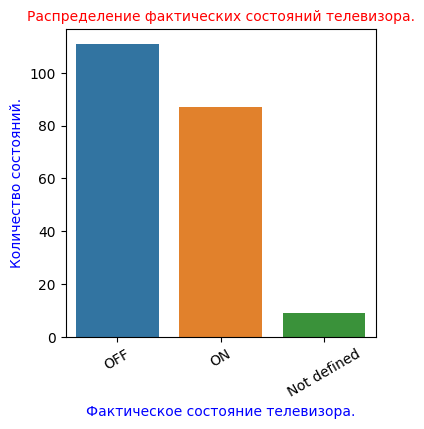

In [18]:
plt.figure(figsize=(4, 4))
my_plot = sns.countplot(x = 'device_state', data = data_survey,
                        order=data_survey.device_state.value_counts().index);
plt.title('Распределение фактических состояний телевизора.', color = 'red', size=10)
plt.xlabel('Фактическое состояние телевизора.', color = 'blue', size=10)
plt.ylabel('Количество состояний.', color = 'blue', size=10)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=30,
                        horizontalalignment='center')

plt.show()

Проверим, почему получились неопределенные значения device_state, отличные от 'On' и 'OFF'.

In [19]:
# Посмотрим все записи в опросном датасете с неопределенными значениями device_state.
data_survey[data_survey.device_state == 'Not defined']

,code,passport,button,tv_state,unit,see,display,num_people,cs_begin,cs_end,device_state
86,258509,1205412,А,включён,0,есть регистрация,в комнате,3,2022-02-16 17:49:40,2022-02-16 17:53:02,Not defined
87,258509,1205412,А,выключен,2,нет регистрации,нет в комнате,3,2022-02-16 17:49:40,2022-02-16 17:53:02,Not defined
88,258509,1205412,А,выключен,1,нет регистрации,нет в комнате,3,2022-02-16 17:49:40,2022-02-16 17:53:02,Not defined
89,258509,1205412,Д,включён,0,нет регистрации,нет в комнате,3,2022-02-16 17:49:40,2022-02-16 17:53:02,Not defined
90,258509,1205412,Д,выключен,2,нет регистрации,нет в комнате,3,2022-02-16 17:49:40,2022-02-16 17:53:02,Not defined
91,258509,1205412,Д,выключен,1,нет регистрации,нет в комнате,3,2022-02-16 17:49:40,2022-02-16 17:53:02,Not defined
92,258509,1205412,Б,включён,0,нет регистрации,нет в комнате,3,2022-02-16 17:49:40,2022-02-16 17:53:02,Not defined
93,258509,1205412,Б,выключен,2,нет регистрации,нет в комнате,3,2022-02-16 17:49:40,2022-02-16 17:53:02,Not defined
94,258509,1205412,Б,выключен,1,нет регистрации,нет в комнате,3,2022-02-16 17:49:40,2022-02-16 17:53:02,Not defined


**Отмечаем**, что записи с неопределенным значениеми 'device_state' принадлежит одному и тому же клиенту с passport == 1205412 и все они сделаны 2022-02-16.

In [20]:
# Посмотрим все записи с passport_number == 1205412 из датасета с информацией 
# по автоматической регистрации использования телевизора.
data_onoff[data_onoff.passport_number == 1205412]

,passport_number,unit_number,device_state,begin,end
321089,1205412,0,OFF,2022-02-07 02:00:00,2022-02-07 18:35:29
321090,1205412,0,ON,2022-02-07 18:35:29,2022-02-08 00:14:06
321091,1205412,0,OFF,2022-02-08 00:14:06,2022-02-08 02:00:00
321092,1205412,0,OFF,2022-02-08 02:00:00,2022-02-08 08:18:25
321093,1205412,0,ON,2022-02-08 08:18:25,2022-02-08 10:22:01
321094,1205412,0,OFF,2022-02-08 10:22:01,2022-02-08 12:06:55
321095,1205412,0,ON,2022-02-08 12:06:55,2022-02-08 12:47:12
321096,1205412,0,OFF,2022-02-08 12:47:12,2022-02-08 15:28:11
321097,1205412,0,ON,2022-02-08 15:28:11,2022-02-09 00:09:50
321098,1205412,0,OFF,2022-02-09 00:09:50,2022-02-09 02:00:00


**Отмечаем**, что записей с с passport_number == 1205412 много. Выберем из них только те, что сделаны 2022-02-16.

In [21]:
data_onoff['day'] = data_onoff['begin'].dt.date
data_onoff['day'] = pd.to_datetime(data_onoff['day'])
print('2022-02-16:')
display(data_onoff[(data_onoff.passport_number == 1205412) &
                   (data_onoff.day == '2022-02-16')])

2022-02-16:


,passport_number,unit_number,device_state,begin,end,day


**Отмечаем**, что в датасете с автоматической регистрацией пользования телевизором `data_onoff` отсутствуют записи с passport_number == 1205412, сделанные 2022-02-16.

Проверим, что на других датах записи выводятся без проблем:

In [22]:
print('2022-02-07:')
display(data_onoff[(data_onoff.passport_number == 1205412) &
                   (data_onoff.day == '2022-02-07')].head(3))

# Ненужные более колонки можно удалить.
data_onoff.drop('day', axis= 1 , inplace= True )

2022-02-07:


,passport_number,unit_number,device_state,begin,end,day
321089,1205412,0,OFF,2022-02-07 02:00:00,2022-02-07 18:35:29,2022-02-07
321090,1205412,0,ON,2022-02-07 18:35:29,2022-02-08 00:14:06,2022-02-07
321142,1205412,2,OFF,2022-02-07 02:00:00,2022-02-07 08:27:35,2022-02-07


**Отмечаем**:
1. Количество состояний OFF и ON отличаются на пару десятков процентов. Аномальных различий в их количестве нет.
2. В нескольких случаях фактическое состояние не определено. Все такие записи принаждежат пользователю с passport = 1205412, сделанные 2022-02-16. 
3. Проверено, что действительно, записей с passport_number = 1205412, сделанные 2022-02-16 в датасете с автоматической регистрацией пользования телевизором 'data_onoff' не существует. Рекомендуется проверить подключение клиента к автоматическому пиплметру. 
4. Менять 'device_state' не буду. Оставлю так, как есть в исходных данных.

**Промежуточные выводы**:
1. Все данные, содержащие информацию по дате и времени, приведение к формату 'datetime' и унифицированы.
2. В датасет с данными опроса добавлен признак 'device_state' с информацией из датасета по измерениями пиплметра.
3. Изучена причина пропусков в созданном 'device_state'. Пропуски заполнены *'Not defined'*.

# 5. Выполнение поставленных заданий.

## 5.1. Задача 1.

Условие задачи: "Количество ситуаций (абс, %), когда прибор фактически выключен (данные в таблице src_OnOff), а респондент утверждает, что включен"

In [23]:
result1 = len(data_survey[(data_survey['device_state'] == 'OFF') & 
                          (data_survey['tv_state'] == 'включён')])
print('Количество ситуаций, когда прибор фактически выключен,' 
      'а респондент утверждает, что включен, равно:', result1)
print('В процентном отношении такое количество: {:.0%}'.
      format(result1/data_survey.device_state.shape[0]))

Количество ситуаций, когда прибор фактически выключен,а респондент утверждает, что включен, равно: 25
В процентном отношении такое количество: 12%


## 5.2. Задача 2.

Условие задачи: "Количество ситуаций (абс, %), когда прибор фактически включен (данные в таблице src_OnOff), а респондент утверждает, что выключен"

In [24]:
result2 = len(data_survey[(data_survey['device_state'] == 'ON') & 
                          (data_survey['tv_state'] == 'выключен')])
print('Количество ситуаций, когда прибор фактически включен,' 
      'а респондент утверждает, что выключен, равно:', result2)
print('В процентном отношении такое количество: {:.0%}'.
      format(result2/data_survey.device_state.shape[0]))

Количество ситуаций, когда прибор фактически включен,а респондент утверждает, что выключен, равно: 61
В процентном отношении такое количество: 29%


## 5.3. Задача 3.

Условие задачи: "Выделить ДХ с размером более 1 человека, среди них ситуации, телевизор фактически включен, респондент по данным опроса находится в комнате с включенным телевизором, регистрации нет, а у других респондентов в этом ДХ регистрация на этом телевизоре есть. Необходимо сгруппировать результат в зависимости от размера ДХ."

Прежде всего рассмотрим распределение опросов по количеству людей в домохозяйствах:

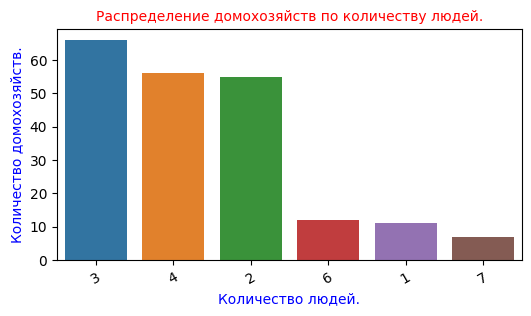

In [25]:
plt.figure(figsize=(6, 3))
my_plot = sns.countplot(x = 'num_people', data = data_survey,
                        order=data_survey.num_people.value_counts().index);
plt.title('Распределение домохозяйств по количеству людей.', color = 'red', size=10)
plt.xlabel('Количество людей.', color = 'blue', size=10)
plt.ylabel('Количество домохозяйств.', color = 'blue', size=10)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=30,
                        horizontalalignment='center')

plt.show()

**Отмечаем**:
* количество людей в домохозяйствах от 1 до 7. Нет домов с 5 хозяевами!
* в основном в домах зарегистрированы от 2 до 4 человек.

In [26]:
'''
Соберем группировкой домохозяйства по количеству жильцов при следующих условиях:
- телевизор фактически включен,        [x['device_state'] == 'ON']
- респондент находится в комнате,      [x['display'] == 'в комнате']
- респондент с включенным телевизором, [x['tv_state'] == 'включён']
- регистрации нет.                     [x['see'] == 'нет регистрации']
'''

df_count = data_survey.groupby(['num_people']).\
    apply(lambda x: x[x['device_state'] == 'ON'] \
          [x['display'] == 'в комнате'] \
          [x['tv_state'] == 'включён'] \
          [x['see'] == 'нет регистрации'].count()
         )
print(df_count)

            code  passport  button  tv_state  unit  see  display  num_people  \
num_people                                                                     
1              0         0       0         0     0    0        0           0   
2              1         1       1         1     1    1        1           1   
3              0         0       0         0     0    0        0           0   
4              0         0       0         0     0    0        0           0   
6              0         0       0         0     0    0        0           0   
7              0         0       0         0     0    0        0           0   

            cs_begin  cs_end  device_state  
num_people                                  
1                  0       0             0  
2                  1       1             1  
3                  0       0             0  
4                  0       0             0  
6                  0       0             0  
7                  0       0             0  

**Отмечаем**, что четырём вышеперечисленным условиям соответствует только 1 запись с количеством респондентов, равным 2.

Проверим этот результат другим образом:

In [27]:
ddd = data_survey[(data_survey.device_state == 'ON') & 
                  (data_survey.display == 'в комнате') & 
                  (data_survey.tv_state == 'включён') &
                  (data_survey.see == 'нет регистрации')
                 ] 

print(len(ddd))
display(ddd)

1


,code,passport,button,tv_state,unit,see,display,num_people,cs_begin,cs_end,device_state
9,258110,1208135,Б,включён,1,нет регистрации,в комнате,2,2022-02-09 14:31:41,2022-02-09 14:33:41,ON


**Отмечаем**, действительно, условиям:
- телевизор фактически включен: `[x['device_state'] == 'ON']`,
- респондент находится в комнате: `[x['display'] == 'в комнате']`,
- респондент с включенным телевизором: `[x['tv_state'] == 'включён']`,
- регистрации нет: `[x['see'] == 'нет регистрации']`  
соответствует единственная запись с passport == 1208135 от 2022-02-09.

В этом домохозяйстве зарегистрированы 2 клиента (см поле 'num_people').

Проверим, есть ли у другого респондента в этом ДХ регистрация на телевизоре:

In [28]:
data_survey[data_survey.passport == 1208135]

,code,passport,button,tv_state,unit,see,display,num_people,cs_begin,cs_end,device_state
6,258110,1208135,А,выключен,2,нет регистрации,нет в комнате,2,2022-02-09 14:31:41,2022-02-09 14:33:41,OFF
7,258110,1208135,А,включён,1,нет регистрации,нет в комнате,2,2022-02-09 14:31:41,2022-02-09 14:33:41,ON
8,258110,1208135,Б,выключен,2,нет регистрации,нет в комнате,2,2022-02-09 14:31:41,2022-02-09 14:33:41,OFF
9,258110,1208135,Б,включён,1,нет регистрации,в комнате,2,2022-02-09 14:31:41,2022-02-09 14:33:41,ON


**Отмечаем**, что у второго клиента этого домохозяйства регистрации на телевизор нет: 'see' = 'нет регистрации'.

**Промежуточный вывод по задаче 3**.

Домохозяйств с условиями:
- телевизор фактически включен: `[x['device_state'] == 'ON']`,
- респондент находится в комнате: `[x['display'] == 'в комнате']`,
- респондент с включенным телевизором: `[x['tv_state'] == 'включён']`,
- регистрации нет: `[x['see'] == 'нет регистрации']`
- у других респондентов в этом ДХ регистрация на этом телевизоре есть  
**не существует**.

## 5.4. Дополнительные задачи.

### 5.4.1. Распределение количества измерений оборудования по дням недели.

In [29]:
# Создадим вспомогательную функцию
def distribution_day_of_week(df, priznak):
    '''
    Функция для создания признака - 'день недели' с буквенным их обозначением
    и печати графика этого распределения.
    '''
    df['weekday'] = df[priznak].dt.weekday  
    df.weekday.replace({0:'Monday',1:'Tuesday',2:'Wednesday',
        3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}, inplace=True)
    
    plt.figure(figsize=(7, 3))
    my_plot = sns.countplot(x = 'weekday', data = df,
                            order=df.weekday.value_counts().index);
    plt.title('Распределение количества измерений оборудования по дням недели.', 
              color = 'red', size=10)
    plt.xlabel('День недели.', color = 'blue', size=10)
    plt.ylabel('Количество измерений.', color = 'blue', size=10)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=30,
                            horizontalalignment='center')

    plt.show()

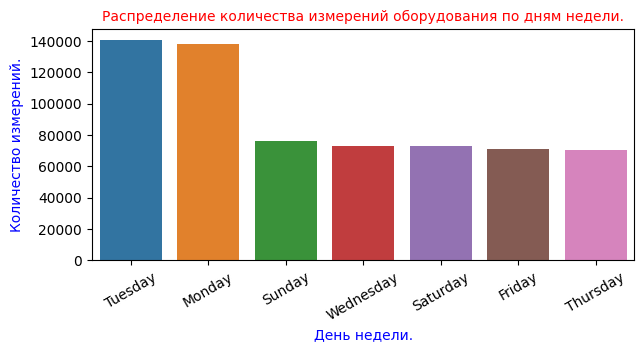

In [30]:
# Распределение автоматических измерение пиплметра по дням недели.
distribution_day_of_week(data_onoff, 'begin')

**Отмечаем**, что в понедельник-вторник автоматическая аппаратура работала раза в 2 чаще по сравнению с другими днями недели.    

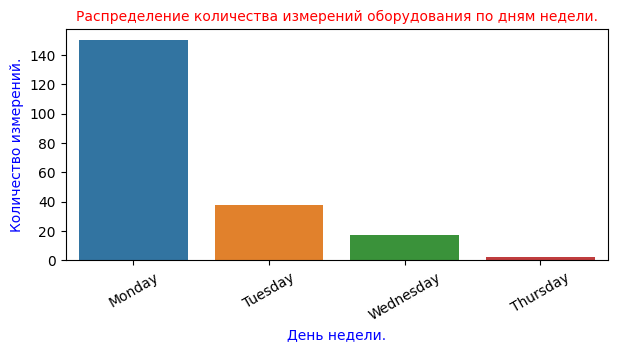

In [31]:
# Распределение количества опросов клиентов тевесетей по дням недели.
distribution_day_of_week(data_survey, 'cs_begin')

**Отмечаем**, что опросы клиентов проводились в рабочие дни, с понедельника по четверг. Преимущественно - по понедельникам.

**Промежуточный вывод**
* Опрос среди клиентов проводился не в самые нагруженные автоматической аппаратуры дни.

### 5.4.2. Распределение количества измерений оборудования по времени суток.

In [32]:
# Создадим вспомогательную функцию
def distribution_of_hours(df, priznak):
    '''
    Функция для создания признака - 'время суток' с буквенным их обозначением
    и печати графика этого распределения.
    '''   
    df['hours'] = (df[priznak].dt.hour % 24 + 4) // 4
    df.hours.replace({1: 'Поздняя ночь',
                      2: 'Раннее утро',
                      3: 'Утро',
                      4: 'День',
                      5: 'Вечер',
                      6: 'Ночь'}, inplace=True)  
    
    plt.figure(figsize=(7, 3))
    my_plot = sns.countplot(x = 'hours', data = df,
                            order=df.hours.value_counts().index);
    plt.title('Распределение количества измерений оборудования по времени суток.', 
              color = 'red', size=10)
    plt.xlabel('Время суток.', color = 'blue', size=10)
    plt.ylabel('Количество измерений.', color = 'blue', size=10)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=30,
                            horizontalalignment='center')

    plt.show()

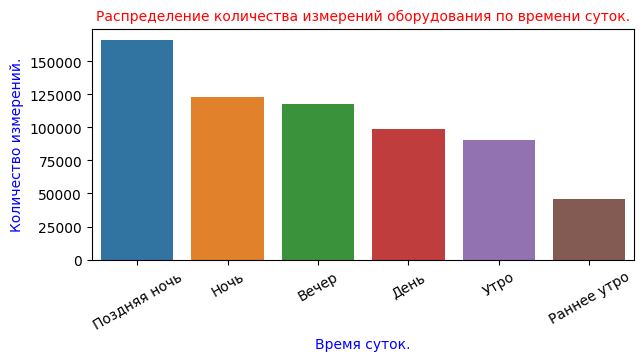

In [33]:
# Распределение автоматических измерение пиплметра по дням недели.
distribution_of_hours(data_onoff, 'begin')

**Отмечаем**, что автоматическая аппаратура работала больше по ночам, нежели в обычное время бодрствования человека. Видимо, фиксировалить выключения телевизионной аппаратуры.

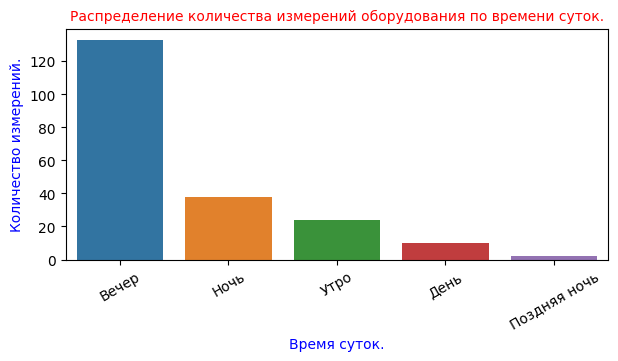

In [34]:
# Распределение количества опросов клиентов тевесетей по дням недели.
distribution_of_hours(data_survey, 'cs_begin')

**Отмечаем**, что опросы клиентов проводились премущественно по вечерам. Что вполне оправдано.

**Промежуточный вывод**
* Зафиксирована наиболее частая работа автоматической аппаратуры в ночное время.
* Опрос клиентов чаще проволдился в удобное для них вечернее время, когда наиболее часто пользуются телевизором.

# 6. Итоговые выводы.

**По результатам исследования можно отметить следующие факты и сделать приводимые ниже выводы:**
    
1. Для проведения исследования получены данные, накопленные в перниод 2022-02-07 по 2022-02-16.
2. В файле `src_OnOff.csv` находятся примерно 640_000 записей по фактическому включению/выключению пиплметра, а в файле `src_survey.csv` - выборка из 207 записей с результатами опроса клиентов телевизионной компании.  
3. Провёл первичную обработку данных и EDA анализ.
4. Выполнил 3 обязательные задачи.  
* **Задача 1**. Вывод - "Количество ситуаций, когда прибор фактически выключен,а респондент утверждает, что включен, равно: 25. В процентном отношении это составляет: **12%**".
* **Задача 2**. Вывод - "Количество ситуаций, когда прибор фактически включен,а респондент утверждает, что выключен, равно: 61. В процентном отношении: **29%**".
* **Задача 3**. Вывод - "Домохозяйств с условиями:
    * телевизор фактически включен: *'device_state' == 'ON'*,
    * респондент находится в комнате: *'display' == 'в комнате'*,
    * респондент с включенным телевизором: *'tv_state'] == 'включён'*,
    * регистрации нет: *'see'] == 'нет регистрации'*,
    * у других респондентов в этом ДХ на этом телевизоре *'есть регистрация'*   
**не существует**."
5. Выполнил 2 дополнительные задачи. 
* **Изучение распределения количества измерений оборудования по дням недели**.  
    Выводы:    
    * Опросы клиентов проводились в рабочие дни, с понедельника по четверг. Преимущественно - по понедельникам.
    * Опрос среди клиентов проводился не в самые нагруженные автоматической аппаратуры дни.
* **Распределение количества измерений оборудования по времени суток**.  
Выводы:    
    * Зафиксирована наиболее частая работа автоматической аппаратуры в ночное время.
    * Опрос клиентов чаще проводился в удобное для них вечернее время, когда наиболее часто пользуются телевизором.